In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
import setup
setup.init_django()
from market import services as market_services

ticker = "NVDA"
days = 720  # Past 2 years

# Fetch 5-minute NVDA data
queryset = market_services.get_5min_stock_quotes_queryset(ticker, days=days)
df_nvda = pd.DataFrame.from_records(list(queryset.values()))

# Convert and clean NVDA data
df_nvda['time'] = pd.to_datetime(df_nvda['time'])
df_nvda.set_index('time', inplace=True)
df_nvda = df_nvda.rename(columns={
    'open_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'close_price': 'Close',
    'volume': 'Volume'
})
df_nvda = df_nvda[['Open', 'High', 'Low', 'Close', 'Volume']]
df_nvda = df_nvda.tz_localize(None)

In [3]:
sp500_path = '../sp500data/SP500PriceHistory.csv'
df_sp500 = pd.read_csv(sp500_path)

# Convert SP500 dates and create proxy
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])
df_sp500.set_index('Date', inplace=True)

# Calculate SP500 daily proxy and SMA200
df_sp500['SP500_Close'] = df_sp500.mean(axis=1)  # Average of all constituents
df_sp500['SP500_SMA200'] = df_sp500['SP500_Close'].rolling(200).mean()

# Resample to 5-minute and forward fill
sp500_5min = df_sp500[['SP500_Close', 'SP500_SMA200']].resample('5T').ffill()

# Align dates with NVDA data
start_date = df_nvda.index.min().floor('D')
end_date = df_nvda.index.max().ceil('D')
sp500_5min = sp500_5min[(sp500_5min.index >= start_date) & 
                       (sp500_5min.index <= end_date)]

# Merge datasets
df_combined = df_nvda.merge(sp500_5min, how='left', left_index=True, right_index=True)
df_combined.ffill(inplace=True)

/tmp/ipykernel_23547/3414409752.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sp500_5min = df_sp500[['SP500_Close', 'SP500_SMA200']].resample('5T').ffill()


In [4]:
class MarketAwareData(bt.feeds.PandasData):
    lines = ('sp500_close', 'sp500_sma200')
    params = (
        ('datetime', None),
        ('open', 0),
        ('high', 1),
        ('low', 2),
        ('close', 3),
        ('volume', 4),
        ('sp500_close', 5),
        ('sp500_sma200', 6)
    )

In [5]:
class IntradayMarketStrategy(bt.Strategy):
    params = (
        ('sma_fast', 20),     # 20 periods (5-min)
        ('sma_slow', 50),     # 50 periods (5-min)
        ('sma_market', 200),  # 200 days (daily)
        ('commission', 0.001),
    )

    def __init__(self):
        # NVDA 5-minute indicators
        self.nvda_sma_fast = bt.ind.SMA(self.data.close, period=self.params.sma_fast)
        self.nvda_sma_slow = bt.ind.SMA(self.data.close, period=self.params.sma_slow)
        self.crossover = bt.ind.CrossOver(self.nvda_sma_fast, self.nvda_sma_slow)
        
        # SP500 daily market condition
        self.market_condition = self.data.sp500_close > self.data.sp500_sma200
        
        # Track trading days
        self.last_market_check = None

    def next(self):
        # Check market condition once per day at market close
        current_date = self.data.datetime.date(0)
        
        # Update market condition daily
        if current_date != self.last_market_check:
            self.last_market_check = current_date
            self.current_market_bullish = self.market_condition[0]
            print(f"\n{current_date} - Market Condition: {self.current_market_bullish}")

        # Trading logic
        if not self.position:
            if self.crossover > 0 and self.current_market_bullish:
                self.order_target_percent(target=1.0)
                print(f"BUY at {self.data.close[0]:.2f}")
        else:
            if self.crossover < 0 or not self.current_market_bullish:
                self.close()
                print(f"SELL at {self.data.close[0]:.2f}")

In [6]:
cerebro = bt.Cerebro()

# Add data feed
data = MarketAwareData(dataname=df_combined)
cerebro.adddata(data)

# Add strategy
cerebro.addstrategy(IntradayMarketStrategy)

# Configure broker
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.001)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

# Execute backtest
print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]
print("\nFinal Portfolio Value: %.2f" % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00

2024-02-21 - Market Condition: 1.0
BUY at 67.95

2024-02-22 - Market Condition: 1.0
BUY at 77.90
BUY at 77.87

2024-02-23 - Market Condition: 1.0
BUY at 80.40
BUY at 80.06

2024-02-24 - Market Condition: 1.0

2024-02-26 - Market Condition: 1.0
BUY at 80.05
BUY at 80.28
BUY at 79.88
BUY at 79.95

2024-02-27 - Market Condition: 1.0
BUY at 78.88
BUY at 79.25

2024-02-28 - Market Condition: 1.0
BUY at 78.10
BUY at 78.90

2024-02-29 - Market Condition: 1.0
BUY at 77.38
BUY at 77.71
BUY at 79.41

2024-03-01 - Market Condition: 1.0
BUY at 79.97

2024-03-02 - Market Condition: 1.0

2024-03-04 - Market Condition: 1.0

2024-03-05 - Market Condition: 1.0
BUY at 85.84
BUY at 85.90
BUY at 85.32
BUY at 85.80

2024-03-06 - Market Condition: 1.0
BUY at 86.81
BUY at 89.00

2024-03-07 - Market Condition: 1.0
BUY at 89.65

2024-03-08 - Market Condition: 1.0
BUY at 95.58
BUY at 87.82

2024-03-09 - Market Condition: 1.0

2024-03-11 - Market Condition: 1.0
BUY at 88.30
B

In [7]:
print("\n--- Strategy Performance ---")
returns_analysis = strat.analyzers.returns.get_analysis()
sharpe_analysis = strat.analyzers.sharpe.get_analysis()
trade_analysis = strat.analyzers.trades.get_analysis()

print(f"Total Return: {returns_analysis.get('rtn100', 0):.2f}%")
print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 0):.2f}")

if trade_analysis.total.closed > 0:
    print(f"\nTrades Closed: {trade_analysis.total.closed}")
    print(f"Win Rate: {trade_analysis.won.total/trade_analysis.total.closed:.2%}")
else:
    print("\nNo trades were executed")


--- Strategy Performance ---
Total Return: 0.00%
Sharpe Ratio: -3.70

Trades Closed: 91
Win Rate: 35.16%


In [8]:
print("\n--- Data Summary ---")
print(f"NVDA Data Range: {df_nvda.index.min()} to {df_nvda.index.max()}")
print(f"SP500 Data Range: {df_sp500.index.min()} to {df_sp500.index.max()}")
print(f"Combined Data NaNs: {df_combined.isnull().sum().sum()}")


--- Data Summary ---
NVDA Data Range: 2024-02-21 09:00:00 to 2025-01-18 00:55:00
SP500 Data Range: 2018-01-02 00:00:00 to 2025-01-23 00:00:00
Combined Data NaNs: 0


In [9]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['backend'] = 'module://matplotlib_inline.backend_inline'

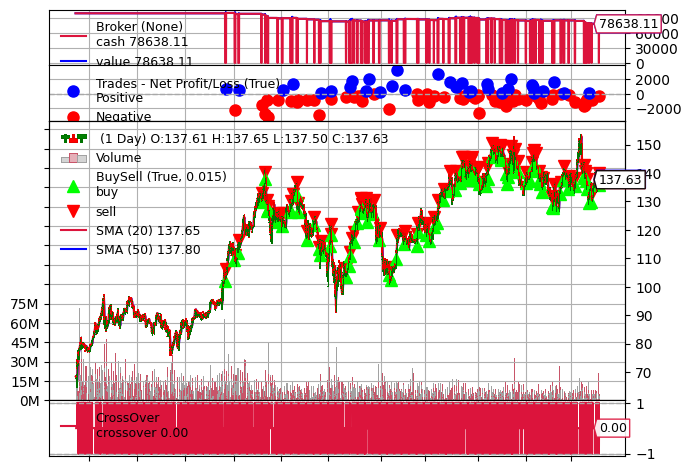

[[<Figure size 640x480 with 5 Axes>]]

In [10]:
cerebro.plot(style='candlestick', 
            iplot=False, 
            volume=True, 
            figsize=(15, 10),
            barup='green', 
            bardown='red',
            subtitles=True,
            plotabove=True,
            overlays=[strat.nvda_sma_fast, strat.nvda_sma_slow])